# Meta-Feature evaluation

# Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_paac, calculate_aac
from subpred.eval import (
    get_independent_test_set,
    optimize_hyperparams,
    preprocess_pandas,
    models_quick_compare,
    get_confusion_matrix,
    get_classification_report,
    full_test,
    quick_test
)
from subpred.util import get_feature_score, perform_pca
from subpred.plots import labeled_clustermap, pca_plot_2d, pca_plot_3d
from subpred.pssm import calculate_pssms_notebook

import pandas as pd

# Dataset

In [2]:
outliers = (
    ["Q9HBR0", "Q07837"]
    + ["P76773", "Q47706", "P02943", "P75733", "P69856", "P64550"]
    + ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0",],
)
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    tax_ids_filter=[3702, 9606, 83333, 559292],
    output_log="../logs/meta_amino_sugar_dataset.log",
    outliers=outliers,
    sequence_clustering=70
)
taxid_to_organism = {
    3702: "A. thaliana",
    9606: "Human",
    83333: "E. coli",
    559292: "Yeast",
}
df = df.assign(organism=df.organism_id.map(taxid_to_organism))

cd-hit: clustered 428 sequences into 362 clusters at threshold 70


# Feature generation

In [3]:
labels = df.keywords_transport
labels.value_counts()

Sugar transport         186
Amino-acid transport    176
Name: keywords_transport, dtype: int64

In [4]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)
df_pssm = calculate_pssms_notebook(df.sequence)

In [5]:
df_combined = pd.concat([
    df_aac, df_paac, df_pssm
], axis=1)
df_combined

,A,C,D,E,F,G,H,I,K,L,...,VL_90_3,VK_90_3,VM_90_3,VF_90_3,VP_90_3,VS_90_3,VT_90_3,VW_90_3,VY_90_3,VV_90_3
Uniprot,,,,,,,,,,,,,,,,,,,,,
P69801,0.150376,0.007519,0.030075,0.022556,0.037594,0.093985,0.015038,0.120301,0.011278,0.101504,...,0.496933,0.487730,0.503067,0.558282,0.450920,0.472393,0.475460,0.490798,0.592025,0.481595
Q9SFG0,0.090730,0.015779,0.033531,0.035503,0.086785,0.088757,0.015779,0.092702,0.033531,0.104536,...,0.434307,0.381387,0.421533,0.578467,0.357664,0.390511,0.392336,0.512774,0.656934,0.417883
Q08986,0.085179,0.025554,0.027257,0.047700,0.069847,0.078365,0.010221,0.091993,0.044293,0.090290,...,0.425047,0.345351,0.402277,0.584440,0.282732,0.351044,0.351044,0.605313,0.759013,0.387097
Q9BRV3,0.058824,0.022624,0.031674,0.018100,0.058824,0.072398,0.009050,0.045249,0.022624,0.176471,...,0.484375,0.403125,0.471875,0.706250,0.368750,0.443750,0.440625,0.568750,0.856250,0.478125
Q84WN3,0.066390,0.004149,0.020747,0.053942,0.070539,0.074689,0.008299,0.070539,0.041494,0.120332,...,0.383260,0.264317,0.374449,0.726872,0.215859,0.286344,0.312775,0.493392,0.982379,0.352423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9FHH5,0.060811,0.020270,0.087838,0.081081,0.020270,0.094595,0.020270,0.020270,0.040541,0.087838,...,0.339130,0.295652,0.304348,0.634783,0.373913,0.365217,0.339130,0.513043,0.747826,0.278261
Q8S8A0,0.108974,0.025641,0.051282,0.096154,0.032051,0.089744,0.025641,0.044872,0.057692,0.083333,...,0.500000,0.532787,0.508197,0.598361,0.483607,0.516393,0.516393,0.557377,0.704918,0.500000
Q3E965,0.083969,0.022901,0.015267,0.106870,0.038168,0.061069,0.007634,0.045802,0.068702,0.091603,...,0.505155,0.556701,0.525773,0.608247,0.505155,0.536082,0.515464,0.587629,0.742268,0.484536


## Plots

First, let's create a plot of the three feature types, and see how they look together in a dataframe:

({'aac': 'cyan', 'paac': 'magenta', 'pssm': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7fe9eb757820>)

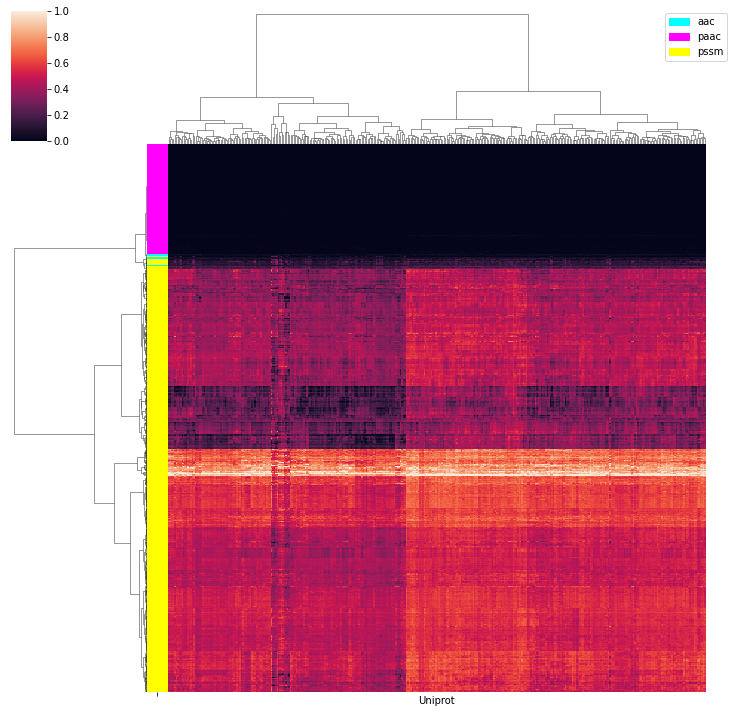

In [6]:
import re

aac = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY]$")
paac = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY]$")
pssm = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY]_\d\d_\d$")

def get_feature_type(feature_name):
    if paac.match(feature_name):
        return "paac"
    elif aac.match(feature_name):
        return "aac"
    elif pssm.match(feature_name):
        return "pssm"
    else:
        raise ValueError("unknown feature type!")

labeled_clustermap(df_combined.T, df_combined.columns.to_series().apply(get_feature_type))

PAAC and AAC values are a lot lower, since they are percentages, while PSSM values are scaled to [0,1]. The scaling was done along the feature axis, to avoid information sharing. What does the data look like when we also scale PAAC and AAC to [0,1]?

({'aac': 'cyan', 'paac': 'magenta', 'pssm': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7fe9e66ae400>)

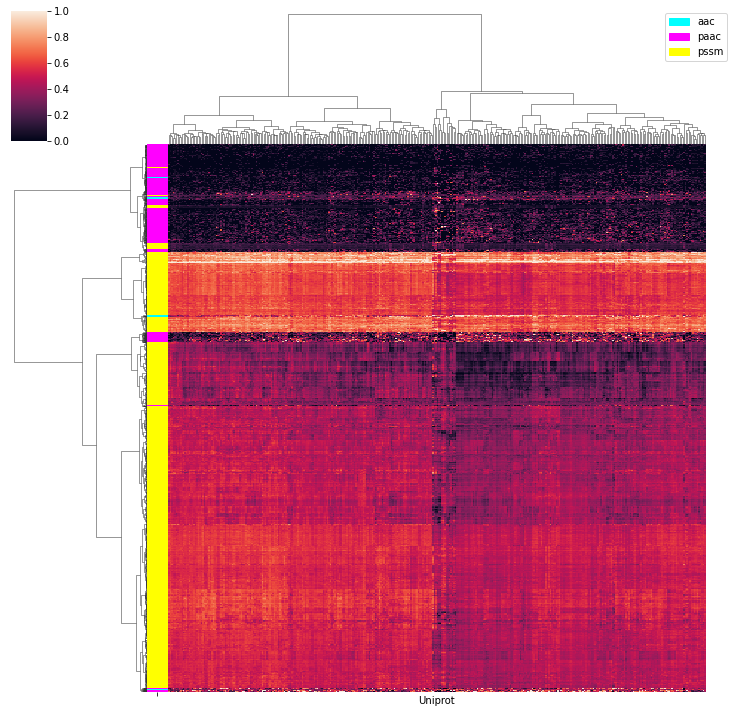

In [7]:
from sklearn.preprocessing import minmax_scale


def min_max_samples(df_feature):
    return pd.DataFrame(
        data=minmax_scale(df_feature, axis=1),
        index=df_feature.index,
        columns=df_feature.columns,
    )


df_combined_minmax = pd.concat(
    [min_max_samples(df_aac), min_max_samples(df_paac), min_max_samples(df_pssm)],
    axis=1,
)
# df_combined_minmax = pd.DataFrame(data=minmax_scale(df_combined, axis=1), index=df_combined.index, columns = df_combined.columns)
labeled_clustermap(
    df_combined_minmax.T, df_combined_minmax.columns.to_series().apply(get_feature_type)
)
# df_combined_minmax#.iloc[0].max()


There is a cluster with almost exclusively PSSM, and one cluster that is more mixed. The latter contains features with lower values.

The feature PCA plot looks similar to the other organisms and also shows the overlap:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

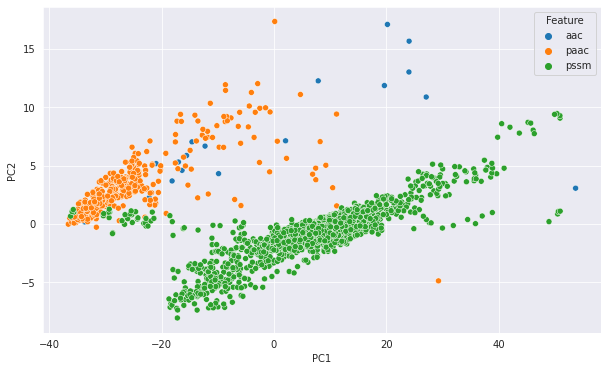

In [8]:
pca_plot_2d(df_combined_minmax.T, df_combined_minmax.T.index.to_series().apply(get_feature_type).rename("Feature"))

What does the data look like when standardizing along the feature axis? In the model, the parameters for this will be derived from the training set and applied to the test set, to avoid data leakage.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fe9d3bc3430>)

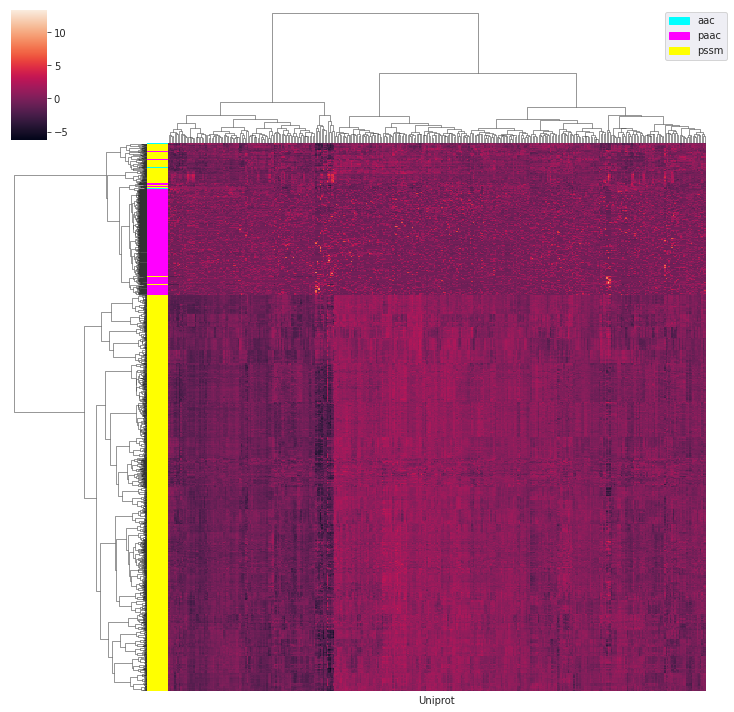

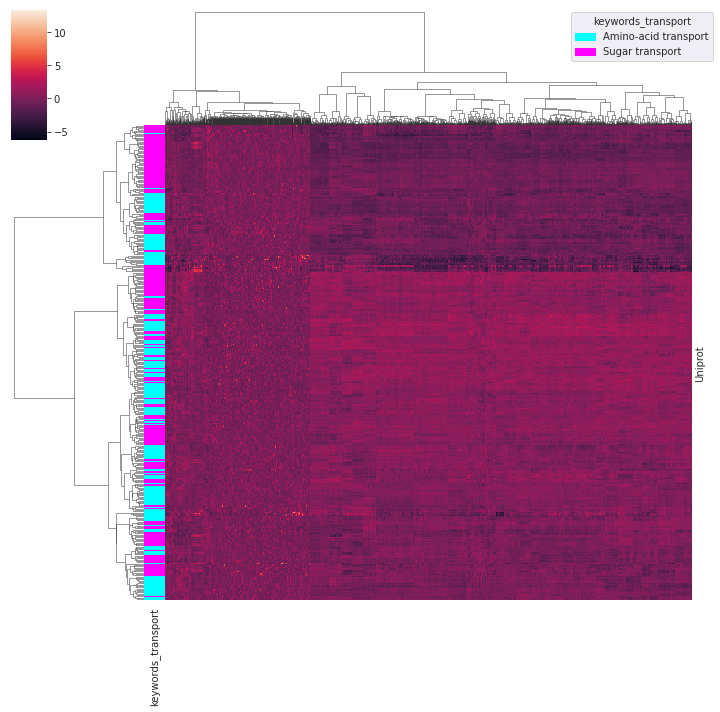

In [9]:
from sklearn.preprocessing import scale

df_combined_std = pd.DataFrame(
    data=scale(df_combined), index=df_combined.index, columns=df_combined.columns
)
labeled_clustermap(
    df_combined_std.T, df_combined.columns.to_series().apply(get_feature_type)
)
labeled_clustermap(
    df_combined_std, df.keywords_transport
)

The composition data looks a bit noisier, however this could also be caused by the fact that more PSSM features exist, and therefore have a higher impact on the h-clustering algorithm. The second plot shows that the two sample clusters do not correspond to the classes. 

There are two clusters, one for PSSM and one for the compositions. There are sub-clusters taht correspond to the substrates

The PCA plot of the standardized features also looks similar. There is a separation between most PSSM features and the rest of the dataset, possibly because of their lower variance

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

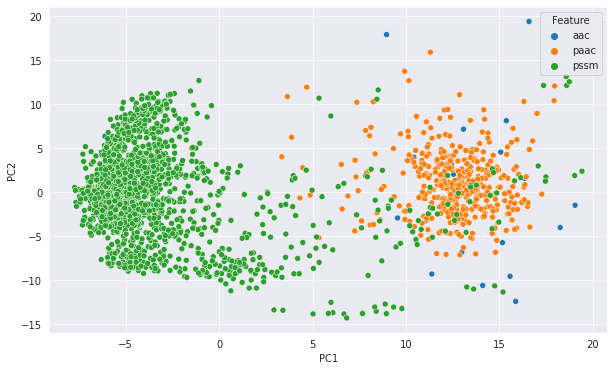

In [10]:
pca_plot_2d(df_combined_std.T, df_combined_std.T.index.to_series().apply(get_feature_type).rename("Feature"))

## Independent test set

In [11]:
X, y, feature_names, sample_names = preprocess_pandas(
    df_combined, labels, return_names=True
)
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2)

## Model comparison

In [12]:
models_quick_compare(X_train, y_train)

,0,1,2,3,4,mean,std
est,,,,,,,
GaussianNB(),0.655,0.684,0.670,0.594,0.630,0.646,0.036
KNeighborsClassifier(),0.791,0.828,0.827,0.758,0.806,0.802,0.029
"LinearSVC(class_weight='balanced', max_iter=1000000.0, random_state=0)",0.879,0.862,0.845,0.810,0.894,0.858,0.033
"LinearSVC(max_iter=1000000.0, random_state=0)",0.879,0.862,0.845,0.810,0.894,0.858,0.033
"RandomForestClassifier(class_weight='balanced', random_state=0)",0.879,0.844,0.828,0.862,0.824,0.847,0.023
RandomForestClassifier(random_state=0),0.931,0.789,0.862,0.862,0.841,0.857,0.051
SGDClassifier(random_state=0),0.845,0.862,0.896,0.776,0.840,0.844,0.044
"SVC(class_weight='balanced', random_state=0)",0.862,0.914,0.931,0.843,0.930,0.896,0.041
SVC(random_state=0),0.845,0.914,0.931,0.843,0.912,0.889,0.042


## Feature importance

How many top 50 features come from each feature type?

In [13]:
top50 = get_feature_score(df_combined, labels, remove_zero_variance=True).sort_values(
    "Normalized score", ascending=False
).head(50)
top50.Feature.apply(get_feature_type).value_counts()

pssm    43
paac     5
aac      2
Name: Feature, dtype: int64

Like in A thaliana and yeast, we get a mix again. For human and e coli, the top50 only came from PSSM.

In [14]:
top50[top50.Feature.apply(get_feature_type) == "pssm"].head(10)

,Feature,Normalized score,Measure
1074,MP_50_3,0.010425,Feature importance (f_classif)
674,MP_50_1,0.009826,Feature importance (f_classif)
1474,MP_90_1,0.008935,Feature importance (f_classif)
1874,MP_90_3,0.008656,Feature importance (f_classif)
605,IQ_50_1,0.005046,Feature importance (f_classif)
1348,EH_90_1,0.004573,Feature importance (f_classif)
1388,HH_90_1,0.004308,Feature importance (f_classif)
1620,AA_90_3,0.003921,Feature importance (f_classif)
548,EH_50_1,0.003803,Feature importance (f_classif)
1788,HH_90_3,0.003716,Feature importance (f_classif)


The most important features are again related to the exchange of Methionine for Proline.

In [15]:
top50[top50.Feature.apply(get_feature_type) == "pssm"].Feature.apply(lambda x: [x[0], x[1]]).explode().value_counts()

H    22
P     8
A     8
D     8
Y     5
R     5
C     4
W     4
M     4
E     4
I     4
Q     2
G     2
K     2
N     1
T     1
S     1
F     1
Name: Feature, dtype: int64

The most important amino acid wrt its conservation was His (H) again. This matches the AAC feature importances of A thaliana and yeast. In human and yeast, Pro was the most important.  

## Parameter tuning

#### Custom transformer


Whole dataset, linear svm

In [16]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[0.01, 0.1, 1, 10],
)

{'linearsvc__C': 1, 'linearsvc__class_weight': None, 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0}
0.862


The PSSMselector selects all pssms, so we get the same score: 

In [17]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[0.01, 0.1, 1, 10],
    feature_transformer="pssm",
    feature_names=feature_names,
)

{'linearsvc__C': 1, 'linearsvc__class_weight': None, 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0, 'pssmselector__iterations': 'all', 'pssmselector__uniref_threshold': 'all'}
0.862


RBF improves the results:

In [18]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[0.1, 1, 10],
)

{'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.914


Removing PSSMs with one iteration leads to a slight improvement:

In [19]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[0.1, 1, 10, 100],
    feature_transformer="pssm",
    feature_names=feature_names,
)
best_estimator_svc = gsearch

{'pssmselector__iterations': 3, 'pssmselector__uniref_threshold': 'all', 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.917


## Dimensionality reduction

Trying only in steps of 20, to reduce runtime.

In [20]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="kbest",
    C=[1, 10, 100],
    select_k_steps=20,
    remove_zero_var=True,
)

{'selectkbest__k': 1841, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.917


In [21]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    # feature_transformer="pssm",
    # feature_names=feature_names,
    # C=[0.1, 0.01, 0.001],
    # gamma=[0.1, 0.01, 0.001],
)


{'pca__n_components': 0.89, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.903


Does using the pssm selector change anything?

In [22]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    feature_transformer="pssm",
    feature_names=feature_names,
    # C=[0.1, 0.01, 0.001],
    # gamma=[0.1, 0.01, 0.001],
)

best_estimator_svc_pca = gsearch

{'pca__n_components': 0.89, 'pssmselector__iterations': 'all', 'pssmselector__uniref_threshold': 'all', 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.903


## Validation



In [23]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_pca, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,33,2
Sugar transport,6,32


In [24]:
get_classification_report(X_test, y_test, best_estimator_svc_pca, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.846,0.943,0.892,35
Sugar transport,0.941,0.842,0.889,38
macro avg,0.894,0.892,0.890,73
weighted avg,0.896,0.890,0.890,73


In [25]:
get_confusion_matrix(X_test, y_test, best_estimator_svc, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,34,1
Sugar transport,9,29


In [26]:
get_classification_report(X_test, y_test, best_estimator_svc, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.791,0.971,0.872,35
Sugar transport,0.967,0.763,0.853,38
macro avg,0.879,0.867,0.862,73
weighted avg,0.882,0.863,0.862,73


## Estimating validation variance

How much did the result depend on choosing the training and test sets?

Mean and standard deviation for randomly selected training and validation sets.

In [27]:
df_scores, df_params = full_test(
    df_combined,
    labels,
    dim_reduction="pca",
    kernel="rbf",
    repetitions=10,
    feature_transformer="pssm",
)
df_scores_gr = df_scores.groupby(["label", "dataset"], as_index=False)
print("Mean F1")
display(df_scores_gr.mean().pivot(index="label", columns="dataset", values="F1 score"))
print("Sdev F1")
display(df_scores_gr.std().pivot(index="label", columns="dataset", values="F1 score"))
print("Parameters")
display(df_params)

Mean F1


dataset,test,train
label,,
Amino-acid transport,0.8543,0.8970
Sugar transport,0.8749,0.9048


Sdev F1


dataset,test,train
label,,
Amino-acid transport,0.042106,0.009309
Sugar transport,0.034459,0.008135


Parameters


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.8,0.97,0.97,0.89,0.94,0.99,0.96,0.86,0.97,0.94
pssmselector__iterations,all,all,all,all,all,all,all,all,all,all
pssmselector__uniref_threshold,all,all,50,all,all,all,all,all,all,all
svc__C,10,10,10,1,10,10,10,1,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__gamma,0.01,0.01,scale,scale,scale,scale,scale,scale,0.01,0.01


The combined feature leads to decent performance, but it does not perform as good as the PSSM feature for the same dataset and the same pipeline.